<a href="https://www.kaggle.com/code/sahidvelji/mnist-digits-with-pytorch?scriptVersionId=99057840" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# MNIST digits with PyTorch

In this notebook, I attempt to document what I have learned about PyTorch. While I have used PyTorch before, I gained a deeper understanding through [PyTorch's tutorials and examples](https://pytorch.org/tutorials/).


Wherever I could, I wrote code that I can reuse as much as possible. For example, while it is definitely possible to make predictions on the test data in one go, I decided to use a dataloader to make predictions in batches instead.

# Importing libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
import random

from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import ExponentialLR
from torch.utils.data import DataLoader, Dataset

# For data augmentation
from albumentations import Compose, ShiftScaleRotate, ToFloat
from albumentations.pytorch import ToTensorV2
import cv2

import plotly.express as px
px.defaults.template = 'plotly_white'
px.defaults.color_discrete_sequence = ['steelblue']

import os
from pathlib import Path
path = Path('/kaggle/input/digit-recognizer')
os.listdir(path)

['sample_submission.csv', 'train.csv', 'test.csv']

Here we fix seeds for reproducibility. This means that we will get the same results each time we run the notebook.

In [2]:
def set_seed(seed=0):
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    os.environ['PYTHONHASHSEED'] = str(seed)
    
set_seed(0)

We will use the variable `device` to indicate whether to use GPU or CPU.

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


# Loading the data

In [4]:
train = pd.read_csv(path/'train.csv')
test = pd.read_csv(path/'test.csv')
sample_sub = pd.read_csv(path/'sample_submission.csv')

In [5]:
train.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [6]:
test.head()

,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [7]:
sample_sub.head()

,ImageId,Label
0,1,0
1,2,0
2,3,0
3,4,0
4,5,0


# Distribution of labels

In [8]:
label_counts = (train.label
                .value_counts()
                .to_frame()
                .reset_index()
                .rename(columns={'index': 'Label', 'label': 'Count'})
                .sort_values('Label')
               )
fig = px.bar(label_counts, x='Label', y='Count')
fig.update_traces(textposition='outside',
                  texttemplate='%{y}',
                  cliponaxis=False,
                  hovertemplate=
                  'Label: <b>%{x}</b><br>'+
                  'Count: <b>%{y}</b>'
                 )
fig.update_layout(title='Distribution of labels',
                  yaxis_title='Count',
                  xaxis_title='Label',
                  xaxis_type='category',
                  yaxis_tickformat=',',
                  hoverlabel_bgcolor="white",
                  hoverlabel_font_size=14,
                  hovermode="x"
                 )
fig.show()

# Splitting the data

Here we split the train data to create a validation set. We'll use 20% of the train data as a validation set. Since the Albumentations library expects a channel dimension, we reshape each image to have the shape (28, 28, 1), where 1 is the channel dimension. Since our images are in grayscale, this dimension is 1. If we had colour images instead, this dimension would be 3 - one each for red, green, and blue (RGB).

In [9]:
X = train.drop(columns='label').values.reshape(-1, 28, 28, 1)
y = train.label.values

train_X, valid_X, train_y, valid_y = train_test_split(X,
                                                      y,
                                                      test_size=0.2
                                                     )

# Dataset and augmentation

In PyTorch, the best way to feed data to the model is with a dataloader. In particular, `torch.utils.data.DataLoader` is an iterator which provides features such as batching, shuffling, and loading data in parallel. In order to use PyTorch's dataloader, we need to create a dataset first. The most flexible way to do this is by creating a custom dataset class that inherits from `torch.utils.data.Dataset`, which is an abstract class. The [PyTorch dataloader tutorial](https://pytorch.org/tutorials/recipes/recipes/custom_dataset_transforms_loader.html#create-a-dataset-class) tells us that we should override the following methods:

> - `__len__` so that `len(dataset)` returns the size of the dataset.
- `__getitem__` to support indexing such that `dataset[i]` can be used to get the $i$th sample

Note that one of the parameters used to initialize the dataset is used to specify transformations to be applied to the image before returning it.

In [10]:
class MNISTDataset(Dataset):
    def __init__(self, X, y=None, is_test=False, transforms=None):
        self.X = X
        self.y = y
        self.is_test = is_test
        self.transforms = transforms

    def __len__(self):
        return len(self.X)

    def __getitem__(self, index):
        image = self.X[index]
        
        if self.transforms:
            image = self.transforms(image=image)['image']
            
        if self.is_test:
            return image
        else:
            return image, self.y[index]

Next, we define the transformations that we will use for the train and validation sets. We use the Compose function to chain together several transformations. Our pixel values are integers between 0 and 255 inclusive. 
- The ToFloat() transform divides the "pixel values by max_value to get a float32 output array where all values lie in the range [0, 1.0]". [[documentation]](https://albumentations.readthedocs.io/en/latest/api/augmentations.html#albumentations.augmentations.transforms.ToFloat)
- We use the ShiftScaleRotate transform to randomly scale the input, randomly shift the input (horizontally and vertically), and randomly rotate the input slightly. We specify p=1 to indicate that we always want to apply ShiftScaleRotate. I will explain what the `border_mode` and `value` parameters are used for below. [[documentation]](https://albumentations.readthedocs.io/en/latest/api/augmentations.html#albumentations.augmentations.transforms.ShiftScaleRotate)
- Finally, we transform the NumPy arrays to PyTorch Tensors with ToTensorV2(). This is necessary because our PyTorch model will expect Tensor inputs. We [use ToTensorV2() instead of ToTensor()](https://albumentations.ai/docs/faq/#which-transformation-should-i-use-to-convert-a-numpy-array-with-an-image-or-a-mask-to-a-pytorch-tensor-totensor-or-totensorv2) because "ToTensor() is now deprecated and will be removed in future versions". It is also important to note that an input shape of (28, 28, 1) will be converted to have a shape of (1, 28, 28) after applying ToTensorV2(). This again has to do with the input that PyTorch expects. Our model will need to have a Tensor input of shape nSamples x nChannels x Height x Width.


In [11]:
train_transforms = Compose([ToFloat(max_value=255),
                            ShiftScaleRotate(shift_limit=0.1,
                                             scale_limit=0.1,
                                             rotate_limit=10,
                                             border_mode=cv2.BORDER_CONSTANT,
                                             value=0,
                                             p=1),
                            ToTensorV2()
                           ])
valid_transforms = Compose([ToFloat(max_value=255),
                            ToTensorV2()
                           ])

Here we display some images and their transformations. The top row consists of a random image from each class. The images in the second row are the original images with transformations applied. At first glance, the images look identical to the original images. However, notice that the 3 is shifted up higher than in the original image. The 8 is slightly rotated to the right and shifted up as well. It also looks like the 6 is shifted down.

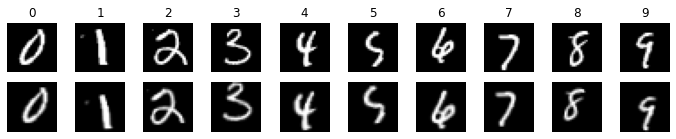

In [12]:
fig = plt.figure(figsize=(12, 2))
for k in range(10):
    idx = random.choice(train.label[train.label.eq(k)].index)
    image, label = train.drop(columns='label').iloc[idx].values.reshape(28, 28), k
    
    ax = plt.subplot(2, 10, k+1)
    ax.title.set_text(label)
    plt.axis('off')
    plt.imshow(image, cmap='gray')
    
    image = np.expand_dims(image, 2)
    image = train_transforms(image=image)['image']
    image = image.squeeze(0)
    ax = plt.subplot(2, 10, 10+k+1)
    plt.axis('off')
    plt.imshow(image, cmap='gray')

In the example below, I have used different arguments for the shift, scale, and rotate limits to make it easier to visualize what happens if we do not specify the `border_mode` and `value` arguments.

In [13]:
example_transforms = Compose([ToFloat(max_value=255),
                            ShiftScaleRotate(shift_limit=0.3,
                                             scale_limit=0.3,
                                             rotate_limit=30,
#                                              border_mode=cv2.BORDER_CONSTANT,
#                                              value=0,
                                             p=1),
                            ToTensorV2()
                           ])

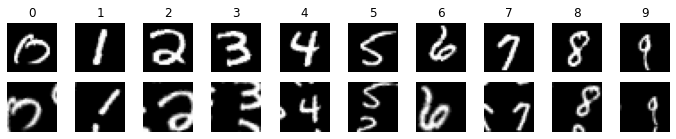

In [14]:
fig = plt.figure(figsize=(12, 2))
for k in range(10):
    idx = random.choice(train.label[train.label.eq(k)].index)
    image, label = train.drop(columns='label').iloc[idx].values.reshape(28, 28), k
    
    ax = plt.subplot(2, 10, k+1)
    ax.title.set_text(label)
    plt.axis('off')
    plt.imshow(image, cmap='gray')
    
    image = np.expand_dims(image, 2)
    image = example_transforms(image=image)['image']
    image = image.squeeze(0)
    ax = plt.subplot(2, 10, 10+k+1)
    plt.axis('off')
    plt.imshow(image, cmap='gray')

The default argument for the `border_mode` parameter is `cv2.BORDER_REFLECT_101`. The above result is obviously not desirable and so we specify `border_mode=cv2.BORDER_CONSTANT` and `value=0` to make the borders black.

# Model architecture

We will see that this simple architecture will achieve an accuracy of over 99%. However, the purpose of this notebook is for me to document what I have learned, and not to achieve the highest accuracy possible (I don't use any ensembles either).

Similarly to how we created a custom dataset, to define a neural network, we inherit from nn.Module and simply implement the `forward()` method. Note that we define two different `nn.BatchNorm2d(48)` layers. Using the same batch normalization layer in multiple parts of the network would be a mistake because the `nn.BatchNorm2d()` class keeps track of the running mean and variance by default.

In [15]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.dropout = nn.Dropout(0.5)
        
        self.bn1_1 = nn.BatchNorm2d(48)
        self.bn1_2 = nn.BatchNorm2d(48)

        self.bn2 = nn.BatchNorm1d(256)
        
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=48, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(in_channels=48, out_channels=48, kernel_size=3, stride=2, padding=1)
        
        self.fc1 = nn.Linear(in_features=48 * 14 * 14, out_features=256)
        self.fc2 = nn.Linear(in_features=256, out_features=10)
        
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.bn1_1(x)
        x = F.relu(self.conv2(x))
        x = self.bn1_2(x)
        x = self.dropout(x)
        
        x = torch.flatten(x, 1)
        
        x = F.relu(self.fc1(x))
        x = self.bn2(x)
        x = self.dropout(x)
        
        x = self.fc2(x)
        return x

# Early stopping class

This early stopping implementation is based on the following three implementations that I found:

- https://github.com/pytorch/ignite/blob/master/ignite/handlers/early_stopping.py
- https://gist.github.com/stefanonardo/693d96ceb2f531fa05db530f3e21517d
- https://github.com/Bjarten/early-stopping-pytorch/blob/master/pytorchtools.py

Early stopping allows us to terminate training if the validation loss stops improving for a certain number of epochs. This number is often referred to as 'patience'. Additionally, we use this class to save the model every time the validation loss improves. This allows us to load the model with the best validation score after training has stopped.

In [16]:
class EarlyStopping:
    def __init__(self, mode, path, patience=3, delta=0):
        if mode not in {'min', 'max'}:
            raise ValueError("Argument mode must be one of 'min' or 'max'.")
        if patience <= 0:
            raise ValueError("Argument patience must be a postive integer.")
        if delta < 0:
            raise ValueError("Argument delta must not be a negative number.")
            
        self.mode = mode
        self.patience = patience
        self.delta = delta
        self.path = path
        self.best_score = np.inf if mode == 'min' else -np.inf
        self.counter = 0
        
    def _is_improvement(self, val_score):
        """Return True iff val_score is better than self.best_score."""
        if self.mode == 'max' and val_score > self.best_score + self.delta:
            return True
        elif self.mode == 'min' and val_score < self.best_score - self.delta:
            return True
        return False
        
    def __call__(self, val_score, model):
        """Return True iff self.counter >= self.patience.
        """
        
        if self._is_improvement(val_score):
            self.best_score = val_score
            self.counter = 0
            torch.save(model.state_dict(), self.path)
            print('Val loss improved. Saved model.')
            return False
        else:
            self.counter += 1
            print(f'Early stopping counter: {self.counter}/{self.patience}')
            if self.counter >= self.patience:
                print(f'Stopped early. Best val loss: {self.best_score:.4f}')
                return True

# Functions

Instead of writing all of our code for training and validation in one cell, it can be helpful to break the different parts into functions.

In [17]:
def train_one_epoch(model, train_loader, optimizer, device, criterion):
    """Train model for one epoch and return the mean train_loss."""
    model.train()
    running_loss_train = 0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss_train += loss.item()
    train_loss = running_loss_train / len(train_loader.dataset)
    return train_loss

After every epoch of training, we compute the validation loss and the validation accuracy. Note that we do not need to compute gradients at this stage, so wrap the validation loop with `torch.no_grad()`.

In [18]:
def validate(model, valid_loader, device, criterion):
    """Validate model and return the accuracy and mean loss."""
    model.eval()
    correct = 0
    running_loss_val = 0
    with torch.no_grad():
        for inputs, labels in valid_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            pred = outputs.argmax(dim=1)
            correct += pred.eq(labels).sum().item()
            running_loss_val += loss.item()
    val_acc = correct / len(valid_loader.dataset)
    val_loss = running_loss_val / len(valid_loader.dataset)
    return val_acc, val_loss

We use the cross entropy loss and the Adam optimizer. We also decay our learning rate by multiplying the learning rate by 0.95 every epoch. If our validation loss does not improve after 5 consecutive epochs, we stop training.

In [19]:
def fit(model, train_loader, valid_loader, learning_rate, num_epochs):
    criterion = nn.CrossEntropyLoss(reduction='sum')
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    es = EarlyStopping(mode='min', path='model.pth', patience=5)
    model = model.to(device)
    scheduler = ExponentialLR(optimizer, gamma=0.9)

    for epoch in range(1, num_epochs + 1):
        train_loss = train_one_epoch(model, train_loader, optimizer, device, criterion)
        val_acc, val_loss = validate(model, valid_loader, device, criterion)
        scheduler.step()
        print(f'Epoch {epoch:2}/{num_epochs}',
              f'train loss: {train_loss:.4f}',
              f'val loss: {val_loss:.4f}',
              f'val acc: {val_acc:.2%}',
              sep=' | '
             )
        if es(val_loss, model):
            break

# Fitting the model

Note that the validation batch size is larger than the train batch size. This is because unlike the train batch size, the validation batch size is not a hyperparameter. Therefore, our only concern is speed when it comes to validation. I found a validation batch size of 512 to be the fastest here. Note that since the images are small, we could actually just pass the entire validation set to the model at once. But, this turns out to be slower than using a batch size of 512 because the GPU has to wait for the CPU to load all of the images in the validation set into the GPU.

Note that there is no need to shuffle the validation data, unlike the train data. Also, we use `drop_last=True` to indicate that we want to drop the last batch. The last batch is usually smaller than our specified batch size and because we are using batch normalization, our batches should not be too small. Since we are shuffling the training data, dropping the last batch does not have any significant impact on training.

It is always a good idea to tune the Dataloader's `num_workers` parameter. From the PyTorch [documentation](https://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader): 
> num_workers (int, optional) – how many subprocesses to use for data loading. 0 means that the data will be loaded in the main process. (default: 0)

In this case, I found the default of 0 `num_workers` to be best. The best way to set the `num_workers` parameter is by picking the fastest option by trial and error.

In [20]:
TRAIN_BATCH_SIZE = 64
VALID_BATCH_SIZE = 512
NUM_EPOCHS = 50
LEARNING_RATE = 1e-3
NUM_WORKERS = 0
PIN_MEMORY = True

mnist_train = MNISTDataset(train_X, train_y, is_test=False, transforms=train_transforms)
mnist_valid = MNISTDataset(valid_X, valid_y, is_test=False, transforms=valid_transforms)

train_loader = DataLoader(mnist_train, batch_size=TRAIN_BATCH_SIZE, shuffle=True, drop_last=True, num_workers=NUM_WORKERS, pin_memory=PIN_MEMORY)
valid_loader = DataLoader(mnist_valid, batch_size=VALID_BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=PIN_MEMORY)

model = CNN()
start = time.time()
fit(model, train_loader, valid_loader, learning_rate=LEARNING_RATE, num_epochs=NUM_EPOCHS)
print(f'Total training time: {time.time() - start}')
model.load_state_dict(torch.load('model.pth'))

Epoch  1/50 | train loss: 0.3806 | val loss: 0.0841 | val acc: 97.48%
Val loss improved. Saved model.
Epoch  2/50 | train loss: 0.1688 | val loss: 0.0545 | val acc: 98.46%
Val loss improved. Saved model.
Epoch  3/50 | train loss: 0.1420 | val loss: 0.0408 | val acc: 98.70%
Val loss improved. Saved model.
Epoch  4/50 | train loss: 0.1204 | val loss: 0.0410 | val acc: 98.87%
Early stopping counter: 1/5
Epoch  5/50 | train loss: 0.1066 | val loss: 0.0372 | val acc: 98.71%
Val loss improved. Saved model.
Epoch  6/50 | train loss: 0.1033 | val loss: 0.0381 | val acc: 98.87%
Early stopping counter: 1/5
Epoch  7/50 | train loss: 0.0973 | val loss: 0.0357 | val acc: 98.89%
Val loss improved. Saved model.
Epoch  8/50 | train loss: 0.0913 | val loss: 0.0342 | val acc: 98.89%
Val loss improved. Saved model.
Epoch  9/50 | train loss: 0.0796 | val loss: 0.0314 | val acc: 98.88%
Val loss improved. Saved model.
Epoch 10/50 | train loss: 0.0804 | val loss: 0.0305 | val acc: 99.05%
Val loss improved. S

<All keys matched successfully>

# Predict on test set and display predictions/images

Finally, we make predictions on the test data and create a CSV submission file.

In [21]:
TEST_BATCH_SIZE = 512

test_transforms = Compose([ToFloat(max_value=255),
                           ToTensorV2()
                          ])

test_X = test.values.reshape(-1, 28, 28, 1)
mnist_test = MNISTDataset(test_X, is_test=True, transforms=test_transforms)
test_loader = DataLoader(mnist_test, batch_size=TEST_BATCH_SIZE, shuffle=False)

In [22]:
def predict(model, test_loader, device):
    """Make predictions on the test data and return 
    the submission data frame.
    """
    
    model.eval()
    predictions = sample_sub['Label'].values
    with torch.no_grad():
        for i, inputs in enumerate(test_loader):
            inputs = inputs.to(device)
            outputs = model(inputs)
            pred = outputs.argmax(dim=1).to('cpu').numpy()
            predictions[i*TEST_BATCH_SIZE:i*TEST_BATCH_SIZE+len(inputs)] = pred
    
    output = sample_sub.copy()
    output['Label'] = predictions
    output.to_csv('submission.csv', index=False)
    return output

output = predict(model, test_loader, device)
output

,ImageId,Label
0,1,2
1,2,0
2,3,9
3,4,0
4,5,3
...,...,...
27995,27996,9
27996,27997,7
27997,27998,3
27998,27999,9


Just to make sure that our predictions make sense, we will display 10 different images from the test set for each of the 10 classes. For example, of all the images that the model assigned to class 0, we pick 10 images at random and display them in the first row. We do this for each class.

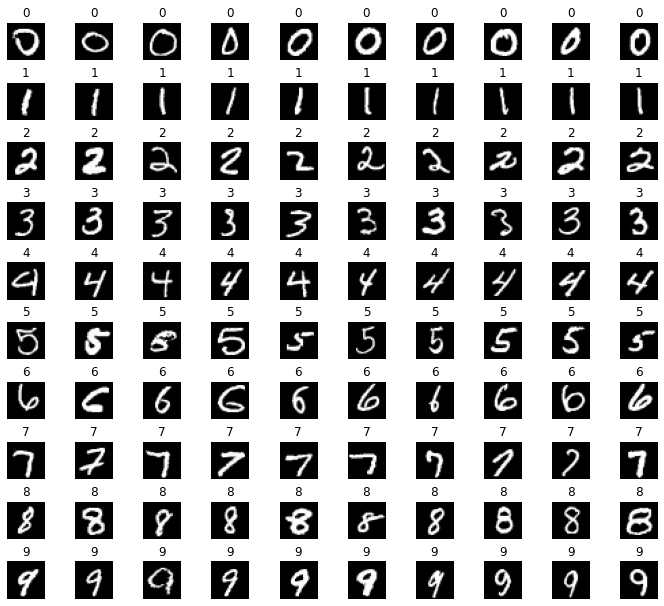

In [23]:
fig = plt.figure(figsize=(12, 10))
for k in range(10):
    indices = output[output.Label.eq(k)].sample(10).index
    for j, idx in enumerate(indices):
        image, label = test_X[idx], output.loc[idx, 'Label'].item()
        image = image.squeeze(2)
        ax = plt.subplot(10, 10, 10*k+j+1)
        ax.title.set_text(label)
        plt.axis('off')
        plt.imshow(image, cmap='gray')

plt.subplots_adjust(left=0.125, bottom=0.1, right=0.9, top=0.9, wspace=0.2, hspace=0.6)

We'll also plot the distribution of predictions.

In [24]:
prediction_counts = (output.Label
                     .value_counts()
                     .to_frame()
                     .reset_index()
                     .rename(columns={'index': 'Prediction', 'Label': 'Count'})
                     .sort_values('Prediction')
                    )
fig = px.bar(prediction_counts, x='Prediction', y='Count')
fig.update_traces(textposition='outside',
                  texttemplate='%{y}',
                  cliponaxis=False,
                  hovertemplate=
                  'Prediction: <b>%{x}</b><br>'+
                  'Count: <b>%{y}</b>'
                 )
fig.update_layout(title='Distribution of predictions',
                  yaxis_title='Count',
                  xaxis_title='Prediction',
                  xaxis_type='category',
                  yaxis_tickformat=',',
                  hoverlabel_bgcolor="white",
                  hoverlabel_font_size=14,
                  hovermode="x"
                 )
fig.show()

This is currently a work in progress.